# A/B Testing

In [15]:
import pandas as pd
import numpy as np
import datetime as dt
from scipy.stats import shapiro, mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

df = pd.read_csv("data/cleaned_online_retail_II.csv")
rfm_df = pd.read_csv("data/rfm_analysis.csv")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], format="%Y-%m-%d %H:%M:%S")
analyse_date = df["InvoiceDate"].max() + dt.timedelta(days=1)

rfm_df.head()

,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,Cluster,Persona
0,12346,529,11,372.86,1,5,2,152,Loyal Customer,0,At-Risk & Lost
1,12347,2,8,4671.93,5,4,5,545,Recent Customer,1,Loyal & Valuable
2,12348,75,5,1659.40,3,4,4,344,Promising Customers,1,Loyal & Valuable
3,12349,19,3,3498.94,5,3,5,535,Recent Customer,1,Loyal & Valuable
4,12350,310,1,294.40,2,1,2,212,Regular Customer,0,At-Risk & Lost


In [16]:
# Selected target audience: "Promising Customers"

promising_customers = rfm_df[rfm_df['Segment'] == 'Promising Customers'].copy()
print(f"There are {len(promising_customers)} customers in the 'Promising Customers' segment.")

# Assign 50% to Group A and 50% to Group B
promising_customers['Group'] = np.random.choice(['A', 'B'], size=len(promising_customers), p=[0.5, 0.5])

# Check the group distribution
print("Group Distribution")
display(promising_customers['Group'].value_counts())

# Create separate dataframes
group_a = promising_customers[promising_customers['Group'] == 'A']
group_b = promising_customers[promising_customers['Group'] == 'B']


There are 1107 customers in the 'Promising Customers' segment.
Group Distribution


Group
A    575
B    532
Name: count, dtype: int64

In [17]:
group_a = group_a.assign(AvgOrderValue=group_a['Monetary'] / group_a['Frequency'])
group_b = group_b.assign(AvgOrderValue=group_b['Monetary'] / group_b['Frequency'])

# Since there is no actual avg purchase value data, we generate synthetic values for demonstration.
# Group A: Current average order values with some random noise added.
# Group B: Spending increased due to the discount. We simulate an average 20% increase plus some noise.

group_a = group_a.assign(
    SyntheticPurchaseValue=(group_a['AvgOrderValue'] * np.random.normal(1.0, 0.1, len(group_a))).abs()
)
group_b = group_b.assign(
    SyntheticPurchaseValue=(group_b['AvgOrderValue'] * np.random.normal(1.2, 0.15, len(group_b))).abs()
)

# Show summary statistics of the simulated data
print("Summary Statistics of Simulated Groups:")
print("Group A (Control):")
display(group_a['SyntheticPurchaseValue'].describe())
print("Group B (Test):")
display(group_b['SyntheticPurchaseValue'].describe())


Summary Statistics of Simulated Groups:
Group A (Control):


count    575.000000
mean     313.401536
std      135.084664
min       77.622213
25%      217.593481
50%      286.622871
75%      383.899226
max      958.031147
Name: SyntheticPurchaseValue, dtype: float64

Group B (Test):


count     532.000000
mean      366.193326
std       168.635101
min       114.212139
25%       248.192785
50%       331.391235
75%       453.230633
max      1488.445923
Name: SyntheticPurchaseValue, dtype: float64

Group A Shapiro-Wilk Test p-value: 0.0000000000
Group B Shapiro-Wilk Test p-value: 0.0000000000


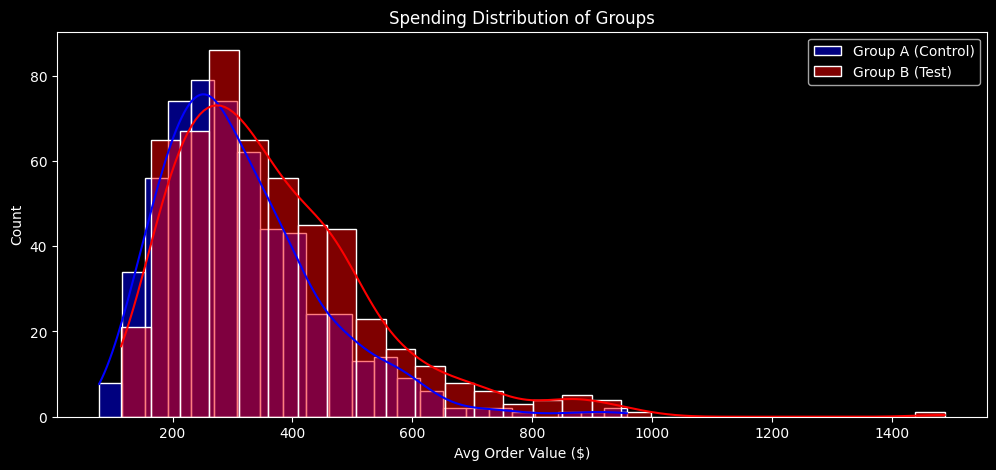

In [18]:
# 1. Normality Assumption (Shapiro-Wilk Test)
# H0: The data follows a normal distribution.
# If p < 0.05, H0 is rejected.
shapiro_a = shapiro(group_a['SyntheticPurchaseValue'])
shapiro_b = shapiro(group_b['SyntheticPurchaseValue'])

print(f"Group A Shapiro-Wilk Test p-value: {shapiro_a.pvalue:.10f}")
print(f"Group B Shapiro-Wilk Test p-value: {shapiro_b.pvalue:.10f}")

# Since both p-values are 0.0000 (less than 0.05), we reject the null hypothesis.
# This indicates that neither group's purchase values follow a normal distribution.
# Therefore, we should use non-parametric tests (like Mann-Whitney U) for group comparisons.

# Let's also check visually
plt.figure(figsize=(12, 5))
sns.histplot(group_a['SyntheticPurchaseValue'], kde=True, color='blue', label='Group A (Control)')
sns.histplot(group_b['SyntheticPurchaseValue'], kde=True, color='red', label='Group B (Test)')
plt.title('Spending Distribution of Groups')
plt.xlabel('Avg Order Value ($)')
plt.legend()
plt.show()

In [19]:
# The p-value is 0.0000 so indicating a statistically significant difference between Group A and Group B.
# This suggests that the campaign had a meaningful impact on purchase value.

stat, p_value = mannwhitneyu(group_b['SyntheticPurchaseValue'], 
                       group_a['SyntheticPurchaseValue'],
                       alternative='two-sided')

print(f"p-value: {p_value:.4f}")

p-value: 0.0000


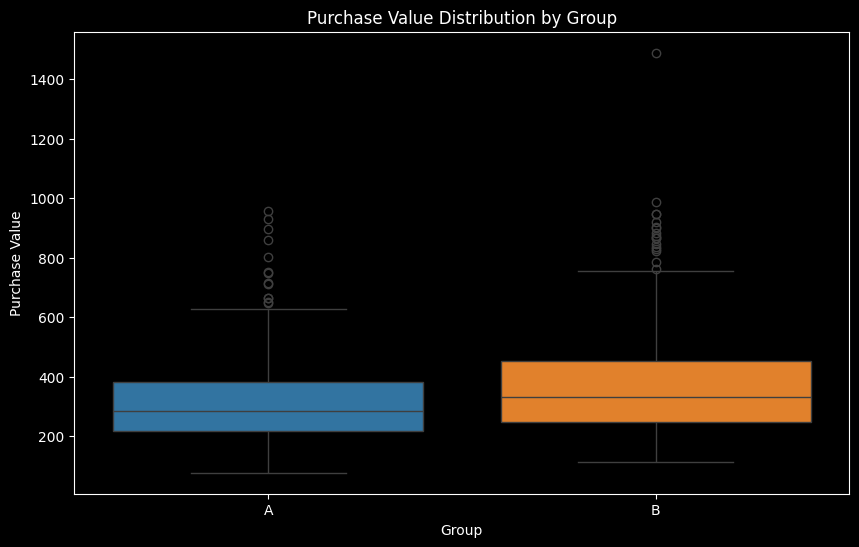

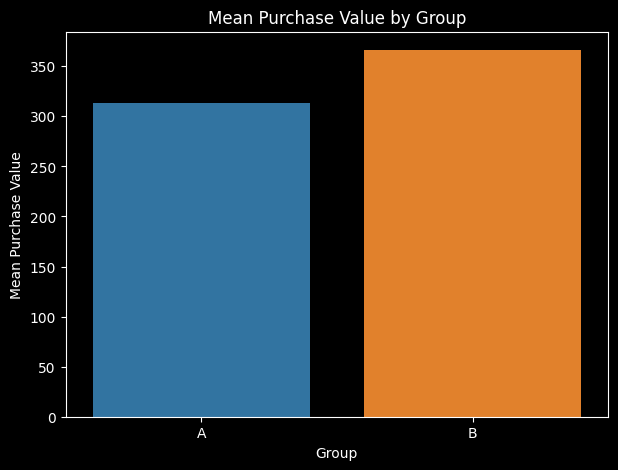

In [20]:
# Visualize the distribution of PurchaseValue for both groups
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=pd.concat([group_a, group_b]),
    x='Group',
    y='SyntheticPurchaseValue',
    hue='Group',
    palette=['#1f77b4', '#ff7f0e'],
    legend=False
)
plt.title('Purchase Value Distribution by Group')
plt.xlabel('Group')
plt.ylabel('Purchase Value')
plt.show()

mean_values = pd.DataFrame({
    'Group': ['A', 'B'],
    'Mean PurchaseValue': [group_a['SyntheticPurchaseValue'].mean(), group_b['SyntheticPurchaseValue'].mean()]
})

# Visualize mean PurchaseValue for each group
plt.figure(figsize=(7, 5))
sns.barplot(
    data=mean_values,
    x='Group',
    y='Mean PurchaseValue',
    hue='Group',
    palette=['#1f77b4', '#ff7f0e'],
    legend=False
)
plt.title('Mean Purchase Value by Group')
plt.ylabel('Mean Purchase Value')
plt.show()

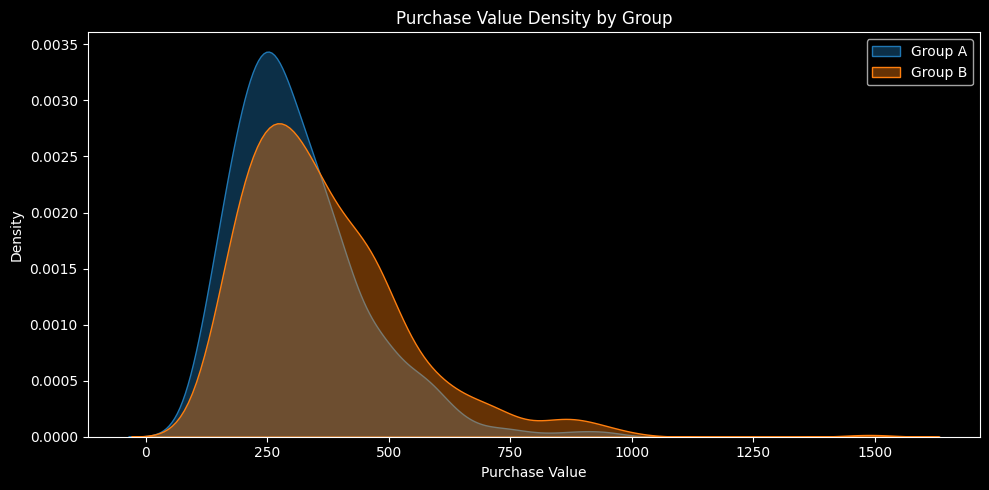

In [21]:
# Distribution of PurchaseValue by Group (density)
plt.figure(figsize=(10, 5))
sns.kdeplot(group_a['SyntheticPurchaseValue'], label='Group A', fill=True, alpha=0.4, color='#1f77b4')
sns.kdeplot(group_b['SyntheticPurchaseValue'], label='Group B', fill=True, alpha=0.4, color='#ff7f0e')
plt.title('Purchase Value Density by Group')
plt.xlabel('Purchase Value')
plt.legend()
plt.tight_layout()
plt.show()



The Mann-Whitney U test results indicate a significant difference in purchase value between Group A (control) and Group B (test).  
This demonstrates that the simulated campaign, which increased spend by 20 percent for Group B, has real potential to impact the customer purchase cycle in the "Promising Customers" segment.

The average purchase value for Group B was higher than for Group A, demonstrating that the campaign was effective.  
The difference is also clearly evident in the visualizations (histogram, boxplot, bar chart).

In short, this simulated A/B test demonstrates that the campaign resulted in a significant increase in average order value.